# Análise da turbina eólica
---

## Introdução
---

A energia eólica é gerada a partir da energia cinética proveniente da força de massas de ar em movimento (ventos), que é captada pelas turbinas dos aerogeradores e, posteriormente, convertida em eletricidade.

Este material encontra-se dividido em três etapas: 
* 1ª Etapa:Tratamento dos dados e analise inicial;
* 2ª Etapa: Análises dos dados e conclusões;

## Objeto de análise
---


**OBJETIVOS DA EMPRESA:** A empresa `HEnergiaRenovável` delimitou as seguintes imposições e pedidos:
* Produção mensal de energia; 
* Produção de energia pela hora do dia;
* Como estão correlacionadas as features;
* Identificar o nível médio de saída de energia para diferentes velocidades do vento;
    * em passos de 5 m/s
* Identificar quais direções de vento produzem maiores erros; 
* Identificar a produção mensal média do ano de 2018 do primeiro semestre;
* Gráficos de comparação entre a potência real e a potência teórica; 
* Identificar os valores de potência zero e fazer uma análise mais detalhada;
    * Identificar os outliers e verificar se devem ser utilizados ou não.
* Gerar arquivo csv contendo os dados não nulos de potência ativa e teórica;
* Dados com 5% para mais ou para menos do limite teórico devem ser desconsiderados;
    * Gerar uma coluna de erros
* Um sistema de predição de potência produzida a partir do banco de dados.
    * Identificar a melhor forma de subdividir o dataframe.
        


## Importações
---

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Análise inicial do dados
---

In [13]:
turbina = pd.read_csv('../dados/T1.csv')
turbina.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


* Verificando o tipos das colunas

In [14]:
turbina.dtypes

Date/Time                         object
LV ActivePower (kW)              float64
Wind Speed (m/s)                 float64
Theoretical_Power_Curve (KWh)    float64
Wind Direction (°)               float64
dtype: object

* Ajustando a coluna do `Date/Time` (convertendo para o tipo datetime)

In [15]:
turbina['Date/Time'] = pd.to_datetime(turbina['Date/Time'])

In [16]:
turbina.dtypes

Date/Time                        datetime64[ns]
LV ActivePower (kW)                     float64
Wind Speed (m/s)                        float64
Theoretical_Power_Curve (KWh)           float64
Wind Direction (°)                      float64
dtype: object

* Vamos renomear as colunas do dataset

In [17]:
turbina.columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [18]:
colunas = {
    'Date/Time':'Tempo',
    'LV ActivePower (kW)':'potencia_ativa',
    'Wind Speed (m/s)':'velocidade_do_vento',
    'Theoretical_Power_Curve (KWh)':'potencia_teorica',
    'Wind Direction (°)':'direcao_do_vento',
}


In [21]:
turbina.rename(columns=colunas, inplace=True)

* Colocando a coluna do tempo como o index

In [26]:
turbina.set_index('Tempo', inplace=True)

In [27]:
turbina

,potencia_ativa,velocidade_do_vento,potencia_teorica,direcao_do_vento
Tempo,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500


* Descrições estatísticas

In [28]:
turbina.describe()

,potencia_ativa,velocidade_do_vento,potencia_teorica,direcao_do_vento
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


* Verificando com as variáveis estão correlacionadas

In [30]:
turbina.corr()

,potencia_ativa,velocidade_do_vento,potencia_teorica,direcao_do_vento
potencia_ativa,1.000000,0.912774,0.949918,-0.062702
velocidade_do_vento,0.912774,1.000000,0.944209,-0.077188
potencia_teorica,0.949918,0.944209,1.000000,-0.099076
direcao_do_vento,-0.062702,-0.077188,-0.099076,1.000000


* Visualizando a correlação graficamente

Text(0.5, 1.0, 'Correlação entre os atributos')

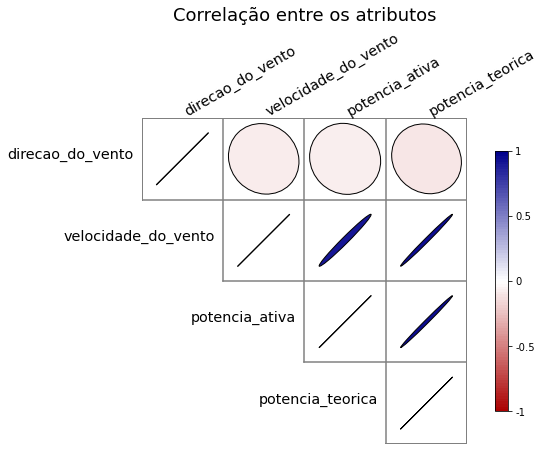

In [35]:
from biokit.viz import corrplot
corr_graph = corrplot.Corrplot(turbina.corr())
corr_graph.plot(upper='ellipse', fontsize='x-large')
fig = plt.gcf()
fig.set_size_inches(13, 8)
plt.title('Correlação entre os atributos', fontsize=18)

## Respondendo as questões
---

### Quantidade mensal de produção de energia
---

Existe alguma diferença entre os meses para a produção média de energia?

In [40]:
colunas = {
    1:'Janeiro',
    2:'Fevereiro',
    3:'Março',
    4:'Abril',
    5:'Maio',
    6:'Junho',
    7:'Julho',
    8:'Agosto',
    9:'Setembro',
    10:'Outubro',
    11:'Novembro',
    12:'Dezembro'
}

# criando um dataframe dos meses
energia_mensal =  turbina.groupby(turbina.index.month).mean()

# renomeando o index
energia_mensal.rename(index=colunas, inplace=True)

# ajustando o nome da coluna do índice
energia_mensal.index.name = 'Meses'

# visualizando o dataframe
energia_mensal

,potencia_ativa,velocidade_do_vento,potencia_teorica,direcao_do_vento
Meses,,,,
Janeiro,1469.538834,9.407847,2051.432742,137.723051
Fevereiro,1398.812191,8.179499,1670.969069,124.670508
Março,1778.547254,9.204149,1899.451986,157.674416
Abril,1062.471714,6.740089,1186.013869,94.857182
Maio,1099.212305,6.693869,1271.246602,104.178431
Junho,1168.209523,6.844458,1330.927093,133.941694
Julho,694.432261,5.474675,781.056052,148.386055
Agosto,1510.816574,8.050320,1695.374114,88.250307
Setembro,1491.921321,7.704346,1601.570319,107.495466


Text(0.5, 0, 'Meses')

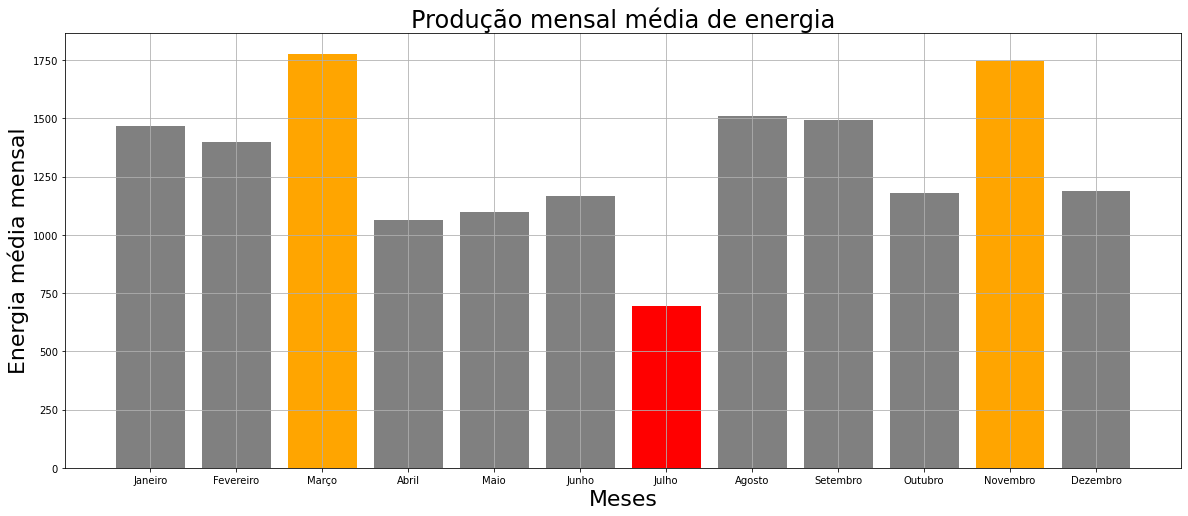

In [53]:
plt.figure(figsize=(20, 8))

# colorindo o gráfico
cores = list(np.full(12, 'grey'))
cores[2], cores[6], cores[10] = 'orange', 'red', 'orange' 

plt.grid()
plt.bar(energia_mensal.index, height=energia_mensal.potencia_ativa, color=cores)
plt.title('Produção mensal média de energia', fontsize=24)
plt.ylabel('Energia média mensal', fontsize=22)
plt.xlabel('Meses', fontsize=22)

###  Quantidade diária de produção de energia
---

Existe alguma diferença entre as horas para a produção média de energia?

### Como estão correlacionadas as features ?
---

### Qual é o nível médio de saída de energia para diferentes velocidades do vento?
---


### Produção de energia no ano de 2018
---


### Velocidade do vento e produção de energia
---


### Qual é o valor limite da velocidade do vento para potência teórica zero?